# model_v0

En el "model-v0", se entrena una red neuronal desde cero.

Además, se aplica la técnica de "Data Augmentation".

Con epoch: 22 > __Recall__: 85,3%

In [1]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y
from funciones import plot_cm, metricas, plot_roc_curve

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
from tensorflow import keras
from keras import regularizers  
from keras import layers 
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, BatchNormalization

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. Procesamiento de datos
==================================================================================================


In [2]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [3]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [4]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

# 2. Definición del modelo
==================================================================================================

Respecto al modelo, probaremos con __redes neuronales__ por ser el tipo de modelos que mejor se justa a la detección de imágenes. Las redes neuronales son conocidas por su nomnbre en inglés: _CNN_ (Convolution Neural Networks).

- Una _convolución_ es simplemente una aplicación de un filtro a las imágenes que le pasemos. Los valores del filtro son pesos. Cuando aplicamos estos pesos de forma repetida a varios _inputs_, entonces, el modelo aprende y es capaz de detectar características específicas en las imágenes (_feature maps_).
- Como las capas convulacionales son sensibiles a la localización específica de las características aprendidas en cada imagen, el modelo aborda este problema tomando estas características fuera del _feature maps_ por medio de parches, los cuales se llaman  _pooling layers_. En definitiva, para identificar patrones relacionados con cada diferente tipo de clasificación, hay cuatro capas: imagen en sí, capa convulacional, no linearidad, y un parche llamado _pooling layer_.

Necesidades del modelo CNN:
- Que las imágenes estén expresadas en 3D en este orden: [rows, columns, channels]
- Si los valores de los píxeles están escalados (por defecto van de 0-255) ayudará bastante

In [5]:
# Comprobamos cómo está expresado cada pixel (hacemos tres slicings: 1. categoría target a la que pertenece, 2. imagen, 3. pixel):
X_train[0][0][0]

array([0.11372549, 0.34117648, 0.3019608 ], dtype=float32)

El modelo __Sequential__ es la forma más fácil de construir un modelo en Keras, una interfaz para la librería TensorFlow. Con este modelo iremos capa por capa, agregándolas mediante la función 'add()'.

In [6]:
# 2D Convolutional Neural Network
'''En convulaciones 2D, es recomendable que previamente se haya procesado la imagen en escala de grises (una profundidad). 
No obstante, los datos están a color (tres profundidades), por lo que tendremos que aplicar 3 filtros tridimensionales. 
Del mismo modo, se aplicarán tres convulaciones en lugar de una.'''

#Definición de un modelo sequencial con tres capas
model = Sequential()
input_shape=(224, 224, 3) # (height, width, depth)
chanDim = -1
init="he_normal"
categorias_a_predecir = 4 
reg = regularizers.l2(0.0005) # método de regularización

# Data augmentation (solo aplica durante las llamadas a Model.fit, y no en Model.evaluate o en Model.predict)
Sequential([
  layers.RandomFlip("horizontal_and_vertical"), 
  layers.RandomRotation(0.2), 
])

# Añadimos cada capa al modelo secuencial
model.add(Conv2D(16, kernel_size=(7,7), strides=(2, 2), padding='valid', # Aplicamos strides evitando utilizar pooling
            kernel_initializer=init, kernel_regularizer=reg,
			input_shape=input_shape)) # Indicamos las dimensiones, para que construya a partir de ahí

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 32 filtros (3,3)
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg)) 
model.add(BatchNormalization(axis=chanDim)) # Estabiliza el training., pero hace más pesado y largo el proceso
model.add(Conv2D(32, kernel_size=(3,3), strides=(2, 2), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg)) # Aprenderá 32 filtros
model.add(BatchNormalization(axis=chanDim)) # Estabiliza el training., pero hace más pesado y largo el proceso
model.add(Dropout(0.25)) # ayuda a generalizar mejor

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 64 filtros (3,3)
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, kernel_size=(3,3), strides=(2, 2), activation='relu', padding='same', 
            kernel_initializer=init, kernel_regularizer=reg))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# Agregamos dos capas conv. superpuestas. Aprenderán un total de 128 filtros (3,3)
keras.layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same')
model.add(BatchNormalization(axis=chanDim))
keras.layers.Conv2D(128,kernel_size=(1,1), strides=(2, 2),activation='relu', padding='same')
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# Fully-conected layers: copila todas las capas para mostrar un resultado único
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init)) # una capa con 512 nodos se añade al modelo
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# softmax classifier: para predicciones multi-clase
model.add(Dense(categorias_a_predecir))
model.add(Activation("softmax")) # el output serán las predicciones


Para componer el modelo, indicaremostres campos:

- __Optimizador__: Utilizamores el optimizador __Adam__, ya que según Kingma et al., 2014 este método es _"computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters"._
 
- __Función de pérdidas__: Utilizaremos el __'Sparse categorical cross entropy'__, muy común para los modelos de clasificación multi-clase. Las funciones de pérdidas (loss functions) muestran cuánto se desvían las estimaciones de su valor real.

- __Métrica__: Utilizamos la métrica __Recall__, la cual muestra el porcentaje de positivos reales que se clasificaron correctamente. Como tratamos de diagnosticar qué plantas de maíz están enfermas, entonces, es de vital importancia identificar bien a todas las que sí que lo estén, y reducir el error de que no queden clasificadas como enfermas. Como segunda métrica decisiva, utilizaremos el F2 score.

In [7]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento del modelo
==================================================================================================

In [8]:
# fit the model
model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=128, 
                    verbose=2, 
                    # class_weight=class_weights
                    )

Epoch 1/5
27/27 - 70s - loss: 0.9392 - accuracy: 0.7918 - 70s/epoch - 3s/step
Epoch 2/5
27/27 - 75s - loss: 0.5060 - accuracy: 0.8886 - 75s/epoch - 3s/step
Epoch 3/5
27/27 - 88s - loss: 0.3883 - accuracy: 0.9307 - 88s/epoch - 3s/step
Epoch 4/5
27/27 - 100s - loss: 0.3278 - accuracy: 0.9591 - 100s/epoch - 4s/step
Epoch 5/5
27/27 - 102s - loss: 0.3307 - accuracy: 0.9546 - 102s/epoch - 4s/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 16)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 55, 55, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0

# Guardamos el modelo

In [16]:
# Vamos a guardar nuestro modelo
if '../model/model_v0' not in os.listdir():
    model.save('../model/model_v0')

INFO:tensorflow:Assets written to: ../model/model_v0\assets


In [11]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model("../model/model_v0")

# 4. Evaluación del modelo
==================================================================================================

In [12]:
metricas(y_test, reconstructed_model.predict(X_test))

Accuracy: 0.641
Precision: 0.702
Recall: 0.641


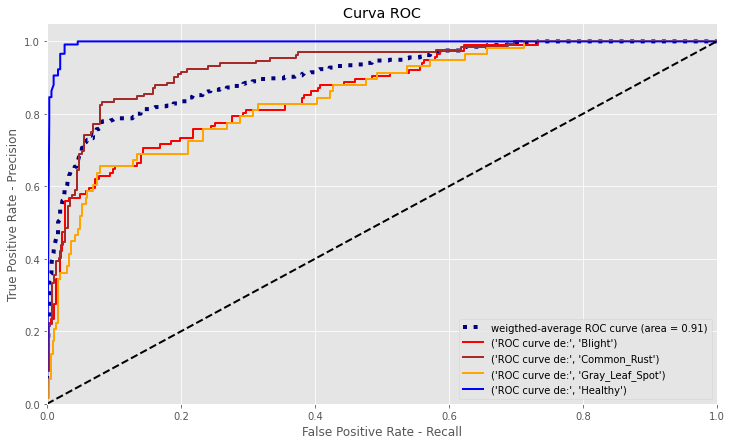

In [13]:
plot_roc_curve(y_test, reconstructed_model.predict(X_test))

In [14]:
# De un vistazo, matriz de confusión
cm = confusion_matrix(y_test, np.argmax(reconstructed_model.predict(X_test), axis=1))
cm_dec = [ cm[i] / np.sum(cm[i]) for i in range(len(cm))]
cm_per = [ [ str(round(x*100,1))+"%" for x in my_list] for my_list in cm_dec ]
cm_per

[['72.4%', '4.3%', '0.9%', '22.4%'],
 ['18.9%', '44.7%', '2.3%', '34.1%'],
 ['63.8%', '3.4%', '19.0%', '13.8%'],
 ['0.0%', '0.0%', '0.0%', '100.0%']]

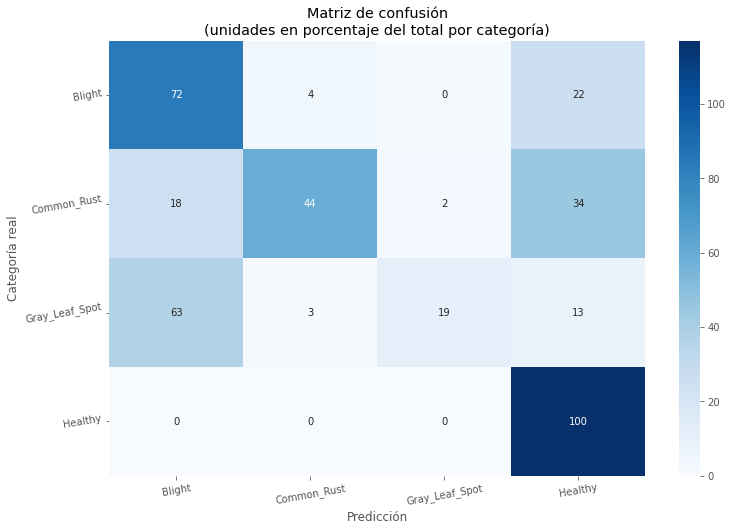

In [15]:
plot_cm(y_test, np.argmax(reconstructed_model.predict(X_test),axis=1))

# Referencias


__Rosebrock, A., (2018)__. _Keras Conv2D and Convolutional Layers_. Extraído de [pyimagesearch](https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)